# Quick Start


This quick start does the following:

- `Install` the package
- `Simulate` a toy dataset with ground truth plots
- `Fit GAM models` including NodeGAM, EBM, XGB-GAM, and Spline
- `Visualize` the GAMs' plots

## Installation


```bash
pip install nodegam
```

## Simulate a toy dataset

To test our package, we simulate a simple binary classification dataset with 3 features sampled from Uniform distributions from -5 to 5 i.e.

$x_0, x_1, x_2 \sim U[-5, 5]$

And the target is simulated as:

$\hat{y} = x_0^2 + 2 * x_1 + sin(x_2)$

and

$y \sim \text{Bern}(sigmoid(\hat{y}))$

In [1]:
from nodegam.sklearn import NodeGAMRegressor, NodeGAMClassifier
from nodegam.gams.MySpline import MySplineLogisticGAM, MySplineGAM
from nodegam.gams.MyEBM import MyExplainableBoostingClassifier, MyExplainableBoostingRegressor
from nodegam.gams.MyXGB import MyXGBOnehotClassifier, MyXGBOnehotRegressor
from nodegam.gams.MyBagging import MyBaggingClassifier, MyBaggingRegressor
from nodegam.utils import sigmoid_np, average_GAM_dfs
from nodegam.vis_utils import vis_GAM_effects

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Generate dataset
N = 25000
x1 = np.random.uniform(-5, 5, size=N)
x2 = np.random.uniform(-5, 5, size=N)
x3 = np.random.uniform(-5, 5, size=N)

f1 = lambda x: (x) ** 2 - 8
f2 = lambda x: x * 2
f3 = lambda x: np.sin(x)

y_prob = sigmoid_np(f1(x1) + f2(x2) + f3(x3))
# Sample
y = (np.random.random(N) < y_prob).astype(int)

X = pd.DataFrame(np.vstack([x1, x2, x3]).T)
X.shape, y.shape

((25000, 3), (25000,))

Ground Truth GAM graph

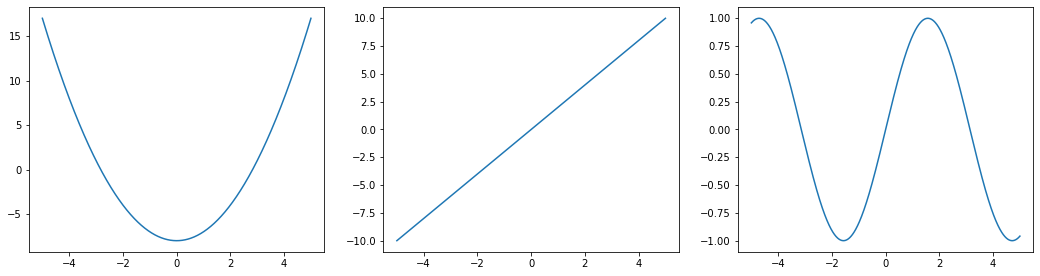

In [7]:
x = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(1, 3, figsize=(18, 4.5))
ax[0].plot(x, f1(x))
ax[1].plot(x, f2(x))
ax[2].plot(x, f3(x))

## Fit GAM Models

We test 4 packages: NodeGAM, Spline, EBM, and XGB.

We train NodeGAM 3 times with different seeds to get stdev on the shape graphs

In [8]:
n_seeds = 3

# NodeGAM fitting
nodegams = []
for seed in range(n_seeds):
    model = NodeGAMClassifier(
        in_features=3,
        objective='ce_loss',
        verbose=False, # Set to True to see the training progress
        seed=seed,
    )
    train_record = model.fit(X, y)
    nodegams.append(model)

Other GAM baselines

In [ ]:
ebm = MyExplainableBoostingClassifier()
ebm.fit(X, y)

spline = MySplineLogisticGAM(verbose=False)
bagged_spline = MyBaggingClassifier(base_estimator=spline, n_estimators=3) # Bagging 3 times to get stdev on the shape graphs
bagged_spline.fit(X, y)

xgb_gam = MyXGBOnehotClassifier()
bagged_xgb = MyBaggingClassifier(base_estimator=xgb_gam, n_estimators=3)
bagged_xgb.fit(X, y)

## Visualization

We visualize the GAM main effects.

100%|██████████| 6/6 [00:00<00:00, 122.51it/s]

bin features 0 with uniq val 24996 to only 256
bin features 1 with uniq val 24993 to only 256
bin features 2 with uniq val 24994 to only 256
Finish "Run values through model" in 99ms
Finish "Extract values" in 53ms



100%|██████████| 7/7 [00:00<00:00, 46.38it/s]

Finish "Purify interactions to main effects" in 60ms
Finish "Center main effects" in 1ms
Finish "Construct table" in 157ms
bin features 0 with uniq val 24996 to only 256
bin features 1 with uniq val 24993 to only 256
bin features 2 with uniq val 24994 to only 256



  0%|          | 0/7 [00:00<?, ?it/s]

Finish "Run values through model" in 93ms
Finish "Extract values" in 52ms
Finish "Purify interactions to main effects" in 66ms
Finish "Center main effects" in 1ms


100%|██████████| 6/6 [00:00<00:00, 123.33it/s]


Finish "Construct table" in 283ms
bin features 0 with uniq val 24996 to only 256
bin features 1 with uniq val 24993 to only 256
bin features 2 with uniq val 24994 to only 256
Finish "Run values through model" in 93ms
Finish "Extract values" in 53ms


100%|██████████| 7/7 [00:00<00:00, 41.94it/s]

Finish "Purify interactions to main effects" in 67ms
Finish "Center main effects" in 1ms
Finish "Construct table" in 172ms


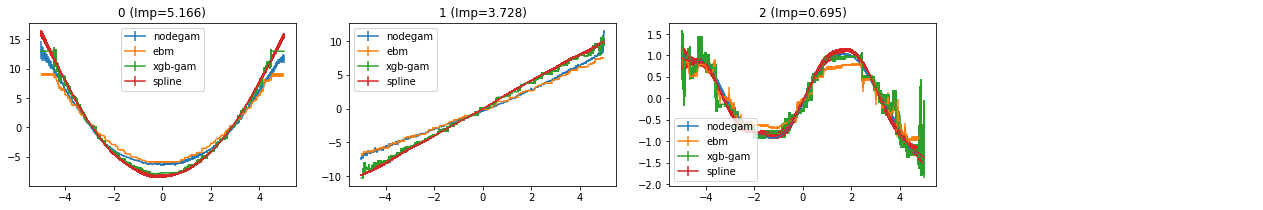

In [11]:
fig, ax = vis_GAM_effects({
    'nodegam': average_GAM_dfs([m.get_GAM_df(X) for m in nodegams]),
    'ebm': ebm.get_GAM_df(),
    'xgb-gam': bagged_xgb.get_GAM_df(),
    'spline': bagged_spline.get_GAM_df(),
}, top_interactions=0)